In [80]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy.interpolate import griddata

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sea_clearly.output_refinery import output_refinery,output_refinery_nearby

import cartopy.crs as ccrs


In [85]:
# data = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/advection.zarr')
land_mask = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Input/landmask.nc')
X_land,Y_land = np.meshgrid(land_mask['lon'],land_mask['lat'])

dlon_coarse = .2
dlat_coarse = .2
x_land_coarse = np.arange(land_mask['lon'].min(),land_mask['lon'].max()+dlon_coarse,dlon_coarse)
y_land_coarse = np.arange(land_mask['lat'].min(),land_mask['lat'].max()+dlat_coarse,dlat_coarse)
X_land_coarse,Y_land_coarse = np.meshgrid(x_land_coarse,y_land_coarse)
land_mask_coarse = griddata((X_land.ravel(),Y_land.ravel()),land_mask['mask_land'].values.ravel(),(X_land_coarse,Y_land_coarse),method='nearest')

/tmp/ipykernel_1306327/789404806.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_land_coarse,Y_land_coarse,land_mask_coarse)


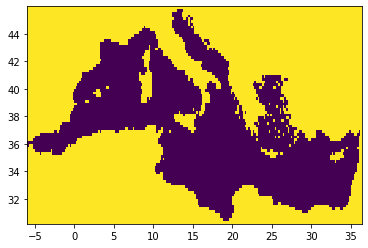

In [98]:
# def refine_merge(files):
files = sorted(glob('/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/*fwd*'))
lon_refine = 5
lat_refine = 39

def refine_concat(files):
    for i1,file in enumerate(files):
        data = xr.open_zarr(file)
        if i1==0:
            data_refined = output_refinery_nearby(data,lon_refine,lat_refine)
        else:
            data_concat = output_refinery_nearby(data,lon_refine,lat_refine)
            data_refined = xr.concat([data_refined,data_concat],dim='traj')
    return data_refined

data_refined = refine_concat(files)

In [9]:
# data2 = output_refinery_nearby(data,lon_refine,lat_refine)
# xr.merge(data_refined,output_refinery_nearby(data,lon_refine,lat_refine))

In [97]:
# data_refined
sorted(files)

['/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/CMEMS_MED_uniform_fwd_4_pergrid_2015-01-01-12:00:00_2015-10-28-12:00:00_-6.00_36.29_30.19_45.98.zarr',
 '/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/CMEMS_MED_uniform_fwd_4_pergrid_2015-01-02-12:00:00_2015-10-29-12:00:00_-6.00_36.29_30.19_45.98.zarr',
 '/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/CMEMS_MED_uniform_fwd_4_pergrid_2015-01-03-12:00:00_2015-10-30-12:00:00_-6.00_36.29_30.19_45.98.zarr',
 '/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/CMEMS_MED_uniform_fwd_4_pergrid_2015-01-04-12:00:00_2015-10-31-12:00:00_-6.00_36.29_30.19_45.98.zarr',
 '/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/CMEMS_MED_uniform_fwd_4_pergrid_2015-01-05-12:00:00_2015-11-01-12:00:00_-6.00_36.29_30.19_45.98.zarr',
 '/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/CMEMS_MED_uniform_fwd_4_pergrid_2015-01-06-12:0

In [31]:
# %timeit data_refined = output_refinery(data,np.arange(-6,36,.1),np.arange(30,46,.1),5,39)
# data_refined = output_refinery(data,np.arange(-6,36,.1),np.arange(30,46,.1),5,39)
len(data_refined['traj'])

480

(31.18839454650879, 44.31882095336914)

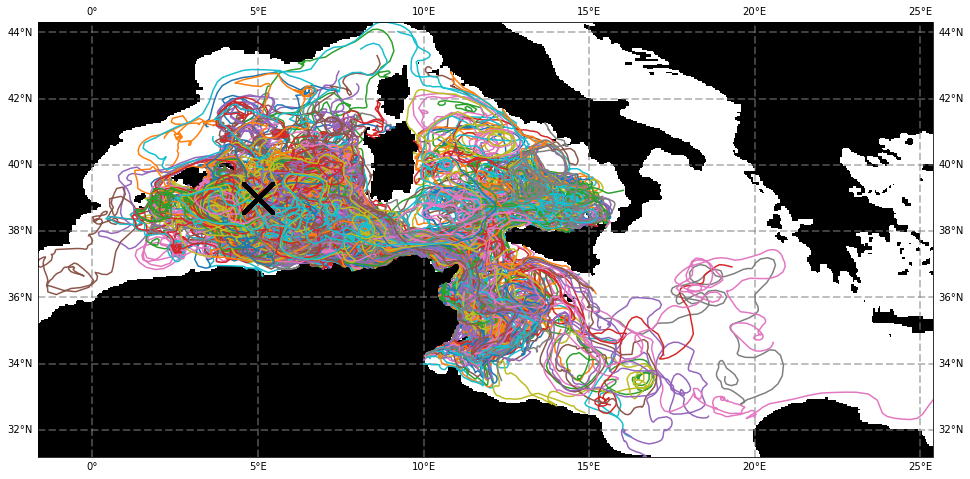

In [34]:
fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines(resolution='50m')
ax.pcolormesh(X_land, Y_land, land_mask['mask_land'][:-1,:-1],cmap='Greys')

for i1 in range(len(data_refined['traj'])):
    ax.plot(data_refined['lon'][i1,:].values,data_refined['lat'][i1,:].values,'-')
for i1 in range(len(data_refined['traj'])):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'kx',markersize=20)
    
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_xlim(data_refined['lon'].min(),data_refined['lon'].max())
ax.set_ylim(data_refined['lat'].min(),data_refined['lat'].max())

In [111]:
data_refined

<xarray.Dataset>
Dimensions:     (traj: 480, obs: 301)
Dimensions without coordinates: traj, obs
Data variables:
    lat         (traj, obs) float32 dask.array<chunksize=(16, 19), meta=np.ndarray>
    lon         (traj, obs) float32 dask.array<chunksize=(16, 19), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(16, 19), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(16, 19), meta=np.ndarray>
    z           (traj, obs) float32 dask.array<chunksize=(16, 19), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-239-g31f81d51

/tmp/ipykernel_1306327/1476564667.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(x_land, y_land, np.log10(hist[0].T))


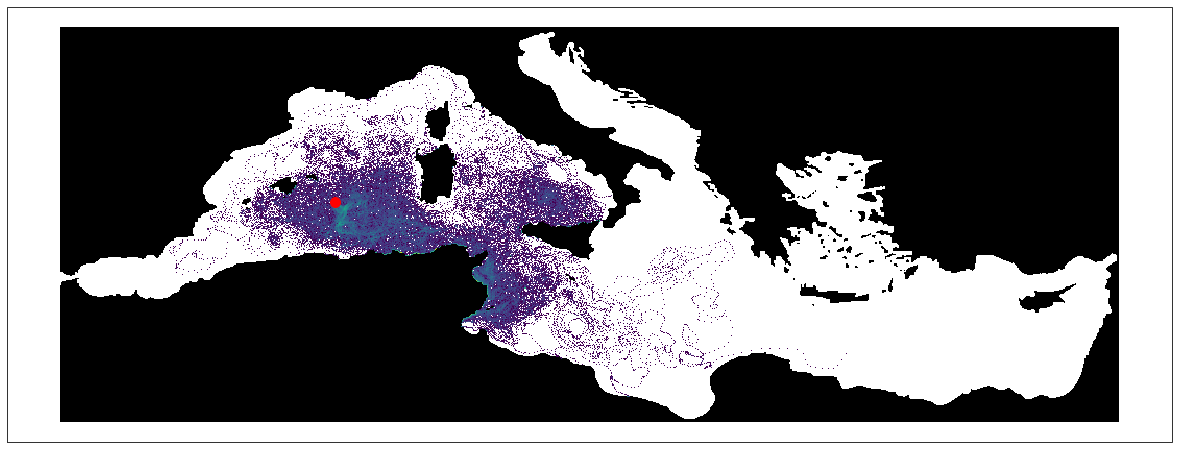

In [64]:
hist = np.histogram2d(data_refined['lon'].values.ravel(),data_refined['lat'].values.ravel(),bins=[land_mask['lon'],land_mask['lat']])

fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines(resolution='50m')
ax.pcolormesh(X_land, Y_land, land_mask['mask_land'][:-1,:-1],cmap='Greys')

ax.pcolormesh(X_land, Y_land, np.log10(hist[0].T))

for i1 in range(1):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'ro',markersize=10)
    

/tmp/ipykernel_1306327/726299623.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(X_land_coarse, Y_land_coarse, np.log10(hist[0].T))


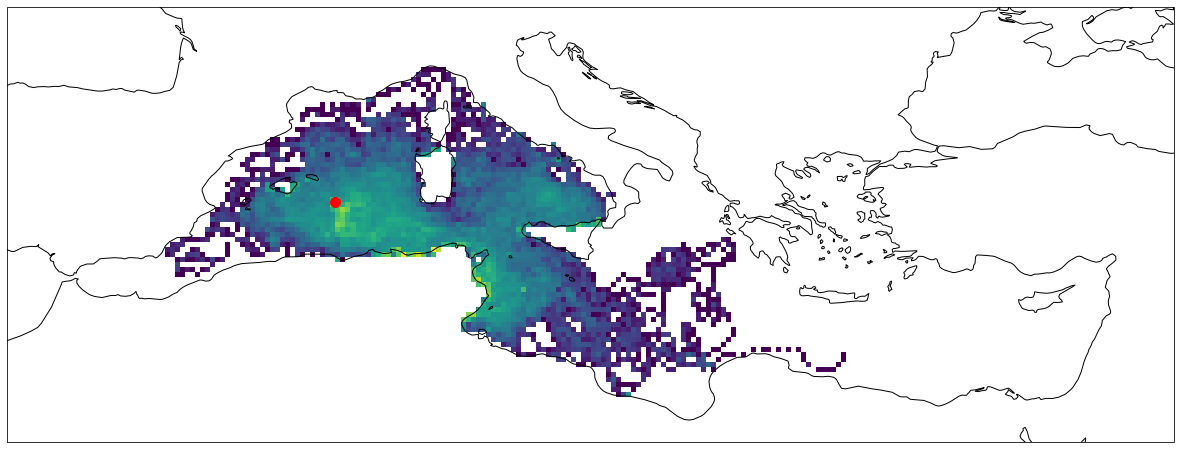

In [110]:
hist = np.histogram2d(data_refined['lon'].values.ravel(),data_refined['lat'].values.ravel(),bins=[x_land_coarse,y_land_coarse])

fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
# ax.pcolormesh(X_land_coarse, Y_land_coarse, land_mask_coarse[:-1,:-1],cmap='Greys')

ax.pcolormesh(X_land_coarse, Y_land_coarse, np.log10(hist[0].T))

for i1 in range(1):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'ro',markersize=10)
    


In [109]:
np.unique(data_refined['trajectory'][:,0].values)

array([409995., 409996., 409997., 409998., 411053., 411054., 411055.,
       411056., 412113., 412114., 412115., 412116., 413175., 413176.,
       413177., 413178.])